In [44]:
import os
import random
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score
from google.colab import files

print("🚀 Step 1: Environment Setup Complete.")
print("Please upload your .mat files now (if not already uploaded).")
# This opens the upload widget
uploaded = files.upload()

🚀 Step 1: Environment Setup Complete.
Please upload your .mat files now (if not already uploaded).


Saving Dog_1_ictal_segment_1.mat to Dog_1_ictal_segment_1.mat
Saving Dog_1_ictal_segment_2.mat to Dog_1_ictal_segment_2.mat
Saving Dog_1_ictal_segment_3.mat to Dog_1_ictal_segment_3.mat
Saving Dog_1_ictal_segment_4.mat to Dog_1_ictal_segment_4.mat
Saving Dog_1_ictal_segment_5.mat to Dog_1_ictal_segment_5.mat
Saving Dog_1_ictal_segment_6.mat to Dog_1_ictal_segment_6.mat
Saving Dog_1_ictal_segment_7.mat to Dog_1_ictal_segment_7.mat
Saving Dog_1_ictal_segment_8.mat to Dog_1_ictal_segment_8.mat
Saving Dog_1_ictal_segment_9.mat to Dog_1_ictal_segment_9.mat
Saving Dog_1_ictal_segment_10.mat to Dog_1_ictal_segment_10.mat
Saving Dog_1_ictal_segment_11.mat to Dog_1_ictal_segment_11.mat
Saving Dog_1_ictal_segment_12.mat to Dog_1_ictal_segment_12.mat
Saving Dog_1_ictal_segment_13.mat to Dog_1_ictal_segment_13.mat
Saving Dog_1_ictal_segment_14.mat to Dog_1_ictal_segment_14.mat
Saving Dog_1_ictal_segment_15.mat to Dog_1_ictal_segment_15.mat
Saving Dog_1_ictal_segment_16.mat to Dog_1_ictal_segment_1

In [46]:
import os
import random

print(" Step 2: Processing Dataset...")

# 1. Scan for files (No upload prompt here)
all_mat_files = []
for root, _, filenames in os.walk("/content"):
    for filename in filenames:
        if filename.endswith(".mat") and 'new_tests' not in root:
            all_mat_files.append(os.path.join(root, filename))

# 2. Separate into Classes (FIXED LOGIC)
ictal_files = []
interictal_files = []

for f in all_mat_files:
    fname = os.path.basename(f).lower()

    # [CRITICAL FIX] Check 'interictal' FIRST to avoid substring errors
    if "interictal" in fname:
        interictal_files.append(f)
    elif "ictal" in fname:
        ictal_files.append(f)

# 3. Random Shuffle (Project Requirement)
random.seed(42) # Fixed seed for reproducibility (optional)
random.shuffle(ictal_files)
random.shuffle(interictal_files)

# 4. 80/20 Stratified Split
ictal_split = int(0.8 * len(ictal_files))
interictal_split = int(0.8 * len(interictal_files))

# Construct Train Set
train_files = ictal_files[:ictal_split] + interictal_files[:interictal_split]
y_train = [1.0] * ictal_split + [0.0] * interictal_split

# Construct Test Set
test_files = ictal_files[ictal_split:] + interictal_files[interictal_split:]
y_test = [1.0] * (len(ictal_files) - ictal_split) + [0.0] * (len(interictal_files) - interictal_split)

# 5. Final Shuffle (Mix classes together)
# Zip -> Shuffle -> Unzip
train_combined = list(zip(train_files, y_train))
random.shuffle(train_combined)
X_train, y_train = zip(*train_combined)

test_combined = list(zip(test_files, y_test))
random.shuffle(test_combined)
X_test, y_test = zip(*test_combined)

print("-" * 40)
print(" Dataset Ready & Randomly Split (80/20)")
print("-" * 40)
print(f"Total files found: {len(all_mat_files)}")
print(f"Training Set: {len(X_train)} files (Seizures: {ictal_split}, Normal: {interictal_split})")
print(f"Testing Set:  {len(X_test)} files (Seizures: {len(ictal_files) - ictal_split}, Normal: {len(interictal_files) - interictal_split})")

 Step 2: Processing Dataset...
----------------------------------------
 Dataset Ready & Randomly Split (80/20)
----------------------------------------
Total files found: 596
Training Set: 476 files (Seizures: 142, Normal: 334)
Testing Set:  120 files (Seizures: 36, Normal: 84)


Randomly visualizing files:
1. Dog_1_interictal_segment_181.mat
2. Dog_1_ictal_segment_119.mat


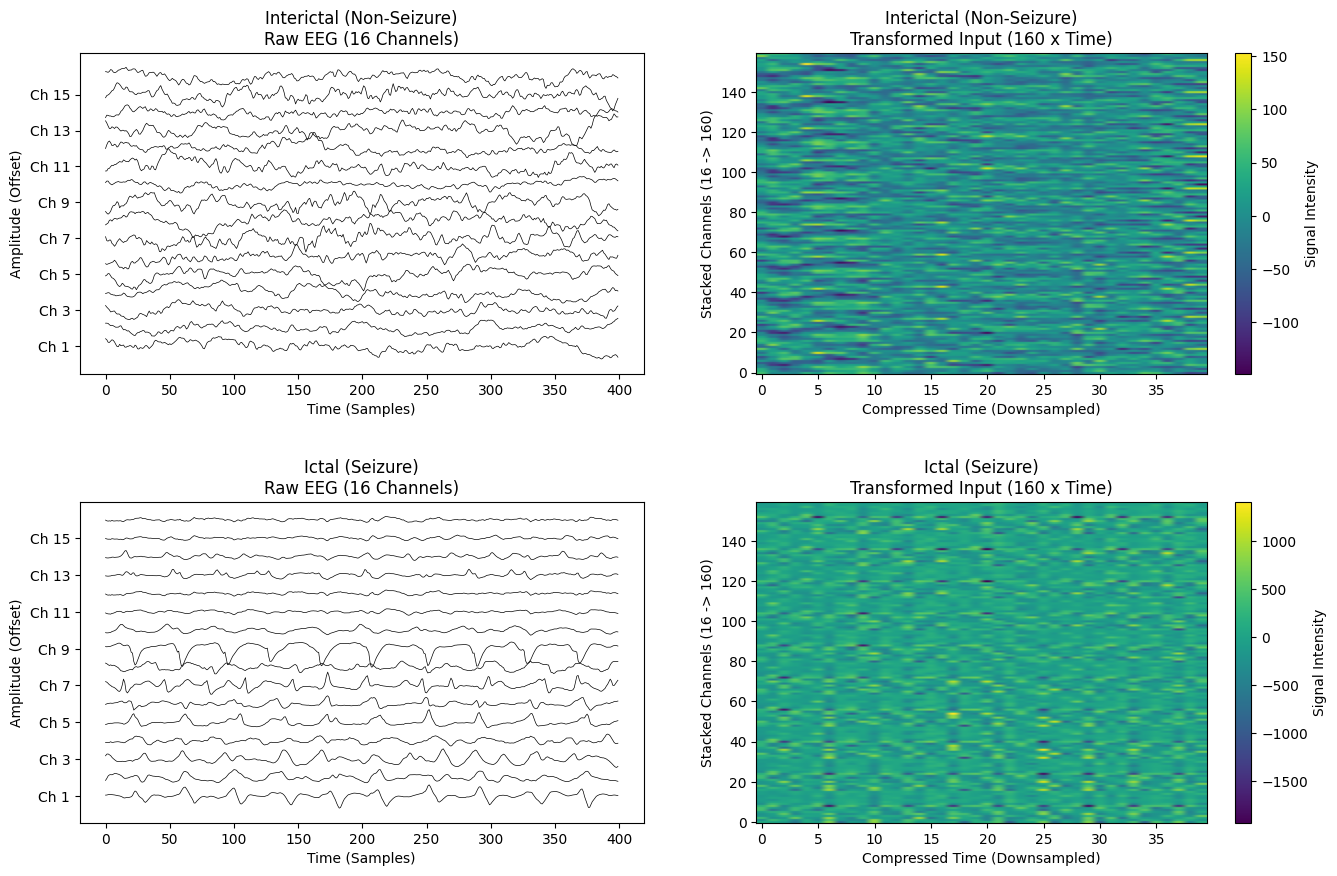

In [49]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import os
import random

def get_random_sample_file(target_type, file_list, seed=None):
    """Randomly select one file of a specific type (ictal/interictal)"""

    # [FIX] Strict filtering to prevent 'ictal' matching 'interictal'
    if target_type == "ictal":
        matching_files = [
            f for f in file_list
            if "ictal" in os.path.basename(f).lower()
            and "interictal" not in os.path.basename(f).lower()
        ]
    else:
        # For interictal, we just look for 'interictal'
        matching_files = [
            f for f in file_list
            if "interictal" in os.path.basename(f).lower()
        ]

    if len(matching_files) == 0:
        return None

    if seed is not None:
        random.seed(seed)

    return random.choice(matching_files)

def visualize_brain_states(file_paths, n_stack=10, seed=None):
    """
    Plots one random Ictal and one random Interictal file.
    seed=None ensures different files are picked every time this runs.
    """
    # 1. Randomly select files
    ictal_file = get_random_sample_file("ictal", file_paths, seed)
    interictal_file = get_random_sample_file("interictal", file_paths, seed)

    # Error handling if files are missing
    if not ictal_file:
        print("❌ Error: No 'Ictal' (seizure) files found.")
        print("Check if your filenames are correct (e.g., must strictly contain 'ictal' but not 'interictal').")
        return
    if not interictal_file:
        print("❌ Error: No 'Interictal' (non-seizure) files found.")
        return

    # List of states to plot
    states = [
        ("Interictal (Non-Seizure)", interictal_file),
        ("Ictal (Seizure)", ictal_file)
    ]

    # 2. Setup Plot (2 Rows x 2 Columns)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4)

    for row_idx, (state_name, file_path) in enumerate(states):
        # Load Raw Data
        mat = sio.loadmat(file_path)
        raw_data = mat['data']  # Shape: (16, TimePoints)

        # --- Apply Converter B (Paper Method) ---
        stacked_list = []
        for i in range(n_stack):
            downsampled = raw_data[:, i::n_stack]
            stacked_list.append(downsampled)

        transformed_data = np.concatenate(stacked_list, axis=0)

        # --- RAW EEG ---
        ax_raw = axes[row_idx, 0]
        ax_raw.set_title(f"{state_name}\nRaw EEG (16 Channels)")

        n_channels = raw_data.shape[0]
        offset_step = np.max(np.abs(raw_data))

        for i in range(n_channels):
            ax_raw.plot(
                raw_data[i, :] + (i * offset_step),
                color='black',
                linewidth=0.5
            )

        ax_raw.set_yticks([i * offset_step for i in range(0, n_channels, 2)])
        ax_raw.set_yticklabels([f'Ch {i+1}' for i in range(0, n_channels, 2)])
        ax_raw.set_xlabel("Time (Samples)")
        ax_raw.set_ylabel("Amplitude (Offset)")

        # --- TRANSFORMED INPUT ---
        ax_trans = axes[row_idx, 1]
        ax_trans.set_title(f"{state_name}\nTransformed Input (160 x Time)")

        im = ax_trans.imshow(
            transformed_data,
            aspect='auto',
            cmap='viridis',
            origin='lower'
        )

        ax_trans.set_xlabel("Compressed Time (Downsampled)")
        ax_trans.set_ylabel("Stacked Channels (16 -> 160)")
        plt.colorbar(im, ax=ax_trans, label="Signal Intensity")

    print(f"Randomly visualizing files:\n1. {os.path.basename(interictal_file)}\n2. {os.path.basename(ictal_file)}")
    plt.show()

# Run visualization
# We use 'all_mat_files' because that is what we created in the previous cell
if 'all_mat_files' in globals() and len(all_mat_files) > 0:
    visualize_brain_states(all_mat_files, seed=None)
else:
    print("⚠️ Warning: 'all_mat_files' not found. Make sure you ran the previous cell (Step 2)!")

In [50]:
def load_data_from_files(file_list):
    processed_data = []
    labels = []

    print(f"Loading {len(file_list)} files...")

    for fpath in file_list:
        fname = os.path.basename(fpath).lower()

        # Determine Label
        if "interictal" in fname: label = 0.0
        elif "ictal" in fname: label = 1.0
        else: continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Normalization
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # Converter B (Stacking)
            stacked_versions = []
            for s in range(10): # N_STACK=10
                shifted = raw_data[:, s::10]
                stacked_versions.append(shifted)

            x = np.concatenate(stacked_versions, axis=0)
            processed_data.append(x)
            labels.append(label)
        except Exception as e:
            print(f"Error: {e}")

    X = torch.tensor(np.array(processed_data)).unsqueeze(2) # Shape: (N, 160, Time, 1)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

# 1. Convert Files to Tensors
X_train, y_train = load_data_from_files(train_files)
X_test, y_test = load_data_from_files(test_files)

# 2. Setup Sampler (Handle Class Imbalance)
class_counts = np.bincount(y_train.numpy())
class_weights = 1. / class_counts
sample_weights = class_weights[y_train.numpy()]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

# 3. Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print("✅ DataLoaders Ready.")

Loading 476 files...
Loading 120 files...
✅ DataLoaders Ready.


pretrained

In [51]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4

# Build Model
def build_model():
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    backbone = models.shufflenet_v2_x0_5(weights=weights)

    # Input Adaptor (160 Ch -> 3 Ch)
    input_adaptor = nn.Conv2d(160, 3, kernel_size=1)

    # Modify Head
    num_ftrs = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024), nn.ReLU(),
        nn.Linear(1024, 256), nn.ReLU(),
        nn.Linear(256, 2)
    )
    return nn.Sequential(input_adaptor, backbone).to(DEVICE)

model = build_model()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training Loop
print(f"Starting Training on {DEVICE}...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Evaluation
    model.eval()
    all_labels, all_probs = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Metrics
    acc = correct / total
    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
    except:
        auroc, auprc = 0.0, 0.0

    print(f"Epoch {epoch+1:02d} | Loss: {running_loss/len(train_loader.dataset):.4f} | "
          f"Acc: {acc:.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

Starting Training on cuda...
Epoch 01 | Loss: 0.6927 | Acc: 0.7000 | AUROC: 0.4544 | AUPRC: 0.3333
Epoch 02 | Loss: 0.6868 | Acc: 0.5333 | AUROC: 0.6190 | AUPRC: 0.3885
Epoch 03 | Loss: 0.6628 | Acc: 0.6000 | AUROC: 0.6111 | AUPRC: 0.4344
Epoch 04 | Loss: 0.6165 | Acc: 0.6000 | AUROC: 0.6151 | AUPRC: 0.3989
Epoch 05 | Loss: 0.5532 | Acc: 0.5917 | AUROC: 0.6478 | AUPRC: 0.4001
Epoch 06 | Loss: 0.5196 | Acc: 0.5583 | AUROC: 0.6362 | AUPRC: 0.3761
Epoch 07 | Loss: 0.4659 | Acc: 0.5500 | AUROC: 0.6263 | AUPRC: 0.3751
Epoch 08 | Loss: 0.4220 | Acc: 0.6167 | AUROC: 0.6911 | AUPRC: 0.4970
Epoch 09 | Loss: 0.3804 | Acc: 0.6000 | AUROC: 0.6961 | AUPRC: 0.5348
Epoch 10 | Loss: 0.3857 | Acc: 0.6167 | AUROC: 0.6690 | AUPRC: 0.5101
Epoch 11 | Loss: 0.4142 | Acc: 0.5833 | AUROC: 0.6524 | AUPRC: 0.5070
Epoch 12 | Loss: 0.2896 | Acc: 0.5750 | AUROC: 0.6647 | AUPRC: 0.5412
Epoch 13 | Loss: 0.2894 | Acc: 0.6000 | AUROC: 0.6554 | AUPRC: 0.5217
Epoch 14 | Loss: 0.2858 | Acc: 0.6083 | AUROC: 0.6713 | AUPRC

In [52]:
def evaluate_with_names(model, test_loader, test_filenames):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    print(f"{'FILENAME':<40} | {'ACTUAL':<8} | {'PRED':<8} | {'CONFID':<8} | {'RESULT'}")
    print("-" * 95)

    correct_count = 0
    total_count = 0
    global_idx = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # 1. Get Softmax probabilities for the 'Seizure' class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get the hard prediction (0 or 1)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                actual = labels[i].item()
                prediction = preds[i].item()
                confidence = probs[i].item() # The probability score

                # Check if we have enough filenames (safety check)
                if global_idx < len(test_filenames):
                    fname = os.path.basename(test_filenames[global_idx])
                else:
                    fname = "Unknown"

                all_labels.append(actual)
                all_probs.append(confidence)

                act_str = "Ictal" if actual == 1 else "Inter"
                pred_str = "Ictal" if prediction == 1 else "Inter"
                is_correct = "correct" if actual == prediction else "incorrect"

                if actual == prediction:
                    correct_count += 1

                # Print row including confidence score
                print(f"{fname[:38]:<40} | {act_str:<8} | {pred_str:<8} | {confidence:.4f} | {is_correct}")

                global_idx += 1
                total_count += 1

    # 3. Final Scientific Metrics Calculation
    final_acc = correct_count / total_count
    try:
        final_auroc = roc_auc_score(all_labels, all_probs)
        final_auprc = average_precision_score(all_labels, all_probs)
    except:
        final_auroc = 0.0
        final_auprc = 0.0

    print("-" * 95)
    print(f" FINAL SUMMARY REPORT")
    print(f"Accuracy: {final_acc:.2%}")
    print(f"AUROC:    {final_auroc:.4f}  (Area Under ROC Curve)")
    print(f"AUPRC:    {final_auprc:.4f}  (Area Under Precision-Recall Curve)")
    print("-" * 95)

# Run evaluation using variables from Cell 2 (test_files) and Cell 4 (test_loader)
evaluate_with_names(model, test_loader, test_files)

FILENAME                                 | ACTUAL   | PRED     | CONFID   | RESULT
-----------------------------------------------------------------------------------------------
Dog_1_ictal_segment_4.mat                | Ictal    | Inter    | 0.0287 | incorrect
Dog_1_ictal_segment_79.mat               | Ictal    | Ictal    | 0.9893 | correct
Dog_1_ictal_segment_3.mat                | Ictal    | Inter    | 0.0505 | incorrect
Dog_1_ictal_segment_59.mat               | Ictal    | Inter    | 0.0279 | incorrect
Dog_1_ictal_segment_153.mat              | Ictal    | Inter    | 0.0487 | incorrect
Dog_1_ictal_segment_76.mat               | Ictal    | Ictal    | 0.7678 | correct
Dog_1_ictal_segment_66.mat               | Ictal    | Inter    | 0.3571 | incorrect
Dog_1_ictal_segment_115.mat              | Ictal    | Ictal    | 0.7884 | correct
Dog_1_ictal_segment_8.mat                | Ictal    | Inter    | 0.0150 | incorrect
Dog_1_ictal_segment_71.mat               | Ictal    | Ictal    | 0.8503

frozen backbone

In [53]:
import os
import time
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score

# ==========================================
# CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
N_STACK = 10

print(f"✅ Training on device: {DEVICE}")

# ==========================================
# 1. LOAD & CONVERT (FROM FILE LISTS)
# ==========================================
def load_and_convert_from_files(file_list):
    processed_data = []
    labels = []

    for fpath in file_list:
        fname = os.path.basename(fpath).lower()

        if "interictal" in fname:
            label = 0
        elif "ictal" in fname:
            label = 1
        else:
            continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Normalization (per-file, no leakage)
            raw_data = (raw_data - raw_data.mean()) / (raw_data.std() + 1e-6)

            # Converter B
            stacked_versions = []
            for s in range(N_STACK):
                stacked_versions.append(raw_data[:, s::N_STACK])

            x = np.concatenate(stacked_versions, axis=0)
            processed_data.append(x)
            labels.append(label)

        except Exception as e:
            print(f"❌ Error reading {fname}: {e}")

    X = torch.tensor(np.array(processed_data)).unsqueeze(2)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

# ==========================================
# 2. USE PRE-SPLIT FILE LISTS
# ==========================================
# REQUIRED (from previous cell):
#   train_files
#   test_files

X_train, y_train = load_and_convert_from_files(train_files)
X_test, y_test = load_and_convert_from_files(test_files)

print(f"Train samples: {len(X_train)} ({int(y_train.sum())} seizures)")
print(f"Test samples:  {len(X_test)} ({int(y_test.sum())} seizures)")

# ==========================================
# 3. DATALOADERS (CLASS BALANCED)
# ==========================================
train_ds = TensorDataset(X_train, y_train)

train_labels_np = y_train.numpy()
class_counts = np.bincount(train_labels_np)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels_np]

sampler = WeightedRandomSampler(
    torch.from_numpy(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("✅ DataLoaders ready (using pre-shuffled files)")

# ==========================================
# 4. MODEL SETUP (FROZEN BACKBONE)
# ==========================================
def build_frozen_model():
    print("\nInitializing ShuffleNet (Frozen Backbone)...")

    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    backbone = models.shufflenet_v2_x0_5(weights=weights)

    # Freeze backbone
    for param in backbone.parameters():
        param.requires_grad = False

    # Input adaptor: 160 → 3 channels
    input_adaptor = nn.Conv2d(160, 3, kernel_size=1)

    # Replace classifier
    num_ftrs = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )

    return nn.Sequential(input_adaptor, backbone).to(DEVICE)

model_frozen = build_frozen_model()

# ==========================================
# 5. OPTIMIZER & LOSS
# ==========================================
trainable_params = filter(lambda p: p.requires_grad, model_frozen.parameters())
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 6. TRAINING LOOP
# ==========================================
def run_training(model, train_loader, test_loader, epochs):
    print("\n--- Starting Training (Frozen Strategy) ---")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Evaluation
        model.eval()
        all_labels, all_probs = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Loss: {running_loss/len(train_loader.dataset):.4f} | "
            f"AUROC: {auroc:.4f} | "
            f"AUPRC: {auprc:.4f}"
        )

    print(f"Training finished in {time.time() - start_time:.0f}s")
    return model

trained_frozen_model = run_training(
    model_frozen,
    train_loader,
    test_loader,
    NUM_EPOCHS
)


✅ Training on device: cuda
Train samples: 476 (142 seizures)
Test samples:  120 (36 seizures)
✅ DataLoaders ready (using pre-shuffled files)

Initializing ShuffleNet (Frozen Backbone)...

--- Starting Training (Frozen Strategy) ---
Epoch 1/20 | Loss: 0.6468 | AUROC: 0.6905 | AUPRC: 0.5441
Epoch 2/20 | Loss: 0.5014 | AUROC: 0.8373 | AUPRC: 0.7060
Epoch 3/20 | Loss: 0.4565 | AUROC: 0.8360 | AUPRC: 0.7785
Epoch 4/20 | Loss: 0.4871 | AUROC: 0.8029 | AUPRC: 0.6905
Epoch 5/20 | Loss: 0.4746 | AUROC: 0.8347 | AUPRC: 0.7062
Epoch 6/20 | Loss: 0.4311 | AUROC: 0.8069 | AUPRC: 0.7225
Epoch 7/20 | Loss: 0.4459 | AUROC: 0.8052 | AUPRC: 0.7283
Epoch 8/20 | Loss: 0.4017 | AUROC: 0.8532 | AUPRC: 0.7738
Epoch 9/20 | Loss: 0.3515 | AUROC: 0.8687 | AUPRC: 0.7717
Epoch 10/20 | Loss: 0.3285 | AUROC: 0.8671 | AUPRC: 0.8209
Epoch 11/20 | Loss: 0.3518 | AUROC: 0.8340 | AUPRC: 0.7648
Epoch 12/20 | Loss: 0.3382 | AUROC: 0.8727 | AUPRC: 0.7637
Epoch 13/20 | Loss: 0.3818 | AUROC: 0.8919 | AUPRC: 0.8185
Epoch 14/2

Running scientific evaluation on test set...

---FROZEN BACKBONE SCIENTIFIC RESULTS ---
Overall Accuracy: 0.8000
AUROC Score:      0.8856
AUPRC Score:      0.7942

Detailed Report:
                     precision    recall  f1-score   support

Interictal (Normal)       0.86      0.86      0.86        84
    Ictal (Seizure)       0.67      0.67      0.67        36

           accuracy                           0.80       120
          macro avg       0.76      0.76      0.76       120
       weighted avg       0.80      0.80      0.80       120



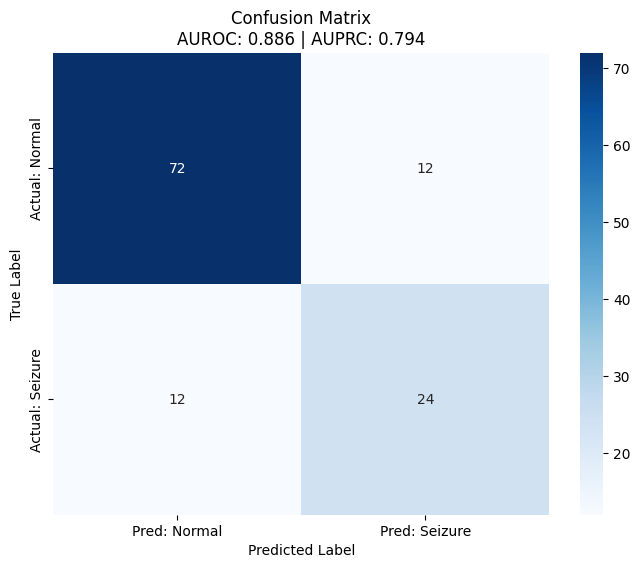

In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_frozen_model(model, test_loader):
    """
    Evaluates the Frozen Backbone model with AUROC and AUPRC metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = [] # To store probabilities for AUROC/AUPRC

    print("Running scientific evaluation on test set...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # 1. Get probabilities for the Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    report = classification_report(all_labels, all_preds,
                                   target_names=['Interictal (Normal)', 'Ictal (Seizure)'])
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n---FROZEN BACKBONE SCIENTIFIC RESULTS ---")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"AUROC Score:      {auroc:.4f}")
    print(f"AUPRC Score:      {auprc:.4f}")
    print("\nDetailed Report:")
    print(report)

    # --- VISUALIZATION ---

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.show()

# Execute Evaluation
if 'trained_frozen_model' in globals():
    test_frozen_model(trained_frozen_model, test_loader)
else:
    print("⚠️ Please run the training cell above first!")

classification head

In [55]:
import os
import time
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import roc_auc_score, average_precision_score
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights

# ==========================================
# CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
N_STACK = 10

print(f"✅ Training on device: {DEVICE}")

# ==========================================
# 1. LOAD & CONVERT (FROM FILE LISTS)
# ==========================================
def load_and_convert_from_files(file_list):
    processed_data = []
    labels = []

    for fpath in file_list:
        fname = os.path.basename(fpath).lower()

        if "interictal" in fname:
            label = 0
        elif "ictal" in fname:
            label = 1
        else:
            continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Per-file normalization (safe)
            raw_data = (raw_data - raw_data.mean()) / (raw_data.std() + 1e-6)

            # Converter B
            stacked_versions = []
            for s in range(N_STACK):
                stacked_versions.append(raw_data[:, s::N_STACK])

            x = np.concatenate(stacked_versions, axis=0)
            processed_data.append(x)
            labels.append(label)

        except Exception as e:
            print(f"❌ Error reading {fname}: {e}")

    X = torch.tensor(np.array(processed_data)).unsqueeze(2)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

# ==========================================
# 2. USE PRE-SPLIT FILE LISTS
# ==========================================
# REQUIRED (from earlier cell):
#   train_files
#   test_files

X_train, y_train = load_and_convert_from_files(train_files)
X_test, y_test = load_and_convert_from_files(test_files)

print(f"Train samples: {len(X_train)} ({int(y_train.sum())} seizures)")
print(f"Test samples:  {len(X_test)} ({int(y_test.sum())} seizures)")

# ==========================================
# 3. DATALOADERS (BALANCED TRAINING)
# ==========================================
train_labels_np = y_train.numpy()
class_counts = np.bincount(train_labels_np)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels_np]

sampler = WeightedRandomSampler(
    torch.from_numpy(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
    sampler=sampler
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("✅ DataLoaders ready (random file-level split)")

# ==========================================
# 4. MODEL SETUP (HEAD TRAINING STRATEGY)
# ==========================================
def build_head_model():
    print("Initializing ShuffleNet (Head Training Strategy)...")

    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    model = models.shufflenet_v2_x0_5(weights=weights)

    # Adapt input: 160 EEG channels → ShuffleNet stem
    model.conv1[0] = nn.Conv2d(
        in_channels=160,
        out_channels=24,
        kernel_size=3,
        stride=2,
        padding=1,
        bias=False
    )

    # Replace classification head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    # Freeze backbone, train only stem + head
    for name, param in model.named_parameters():
        if "fc" in name or "conv1.0" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model.to(DEVICE)

model_head = build_head_model()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_head.parameters()),
    lr=LEARNING_RATE
)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 5. TRAINING & EVALUATION
# ==========================================
print("\n--- Starting Training (Head-Only, Random File Split) ---")

for epoch in range(NUM_EPOCHS):
    model_head.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_head(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Evaluation
    model_head.eval()
    all_labels, all_probs = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_head(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Loss: {running_loss/len(train_loader.dataset):.4f} | "
        f"AUROC: {auroc:.4f} | "
        f"AUPRC: {auprc:.4f}"
    )




✅ Training on device: cuda
Train samples: 476 (142 seizures)
Test samples:  120 (36 seizures)
✅ DataLoaders ready (random file-level split)
Initializing ShuffleNet (Head Training Strategy)...

--- Starting Training (Head-Only, Random File Split) ---
Epoch 1/20 | Loss: 0.6696 | AUROC: 0.5916 | AUPRC: 0.3431
Epoch 2/20 | Loss: 0.5042 | AUROC: 0.8393 | AUPRC: 0.7176
Epoch 3/20 | Loss: 0.4581 | AUROC: 0.7946 | AUPRC: 0.7354
Epoch 4/20 | Loss: 0.3659 | AUROC: 0.8492 | AUPRC: 0.7402
Epoch 5/20 | Loss: 0.3270 | AUROC: 0.8317 | AUPRC: 0.7282
Epoch 6/20 | Loss: 0.2271 | AUROC: 0.8634 | AUPRC: 0.7293
Epoch 7/20 | Loss: 0.3657 | AUROC: 0.8839 | AUPRC: 0.7846
Epoch 8/20 | Loss: 0.2640 | AUROC: 0.8879 | AUPRC: 0.7635
Epoch 9/20 | Loss: 0.2650 | AUROC: 0.8833 | AUPRC: 0.7975
Epoch 10/20 | Loss: 0.2177 | AUROC: 0.9180 | AUPRC: 0.8500
Epoch 11/20 | Loss: 0.2462 | AUROC: 0.8730 | AUPRC: 0.8099
Epoch 12/20 | Loss: 0.2414 | AUROC: 0.8604 | AUPRC: 0.7629
Epoch 13/20 | Loss: 0.2032 | AUROC: 0.8862 | AUPRC:

🔬 Starting Scientific Evaluation for Classification Head Model (Stem + FC) on cuda...

 SCIENTIFIC RESULTS — Classification Head Model (Stem + FC)
Accuracy : 0.8167
AUROC    : 0.9200
AUPRC    : 0.8335
------------------------------------------------------------
Classification Report:
                     precision    recall  f1-score   support

Normal (Interictal)       0.89      0.85      0.87        84
    Seizure (Ictal)       0.68      0.75      0.71        36

           accuracy                           0.82       120
          macro avg       0.78      0.80      0.79       120
       weighted avg       0.82      0.82      0.82       120

------------------------------------------------------------


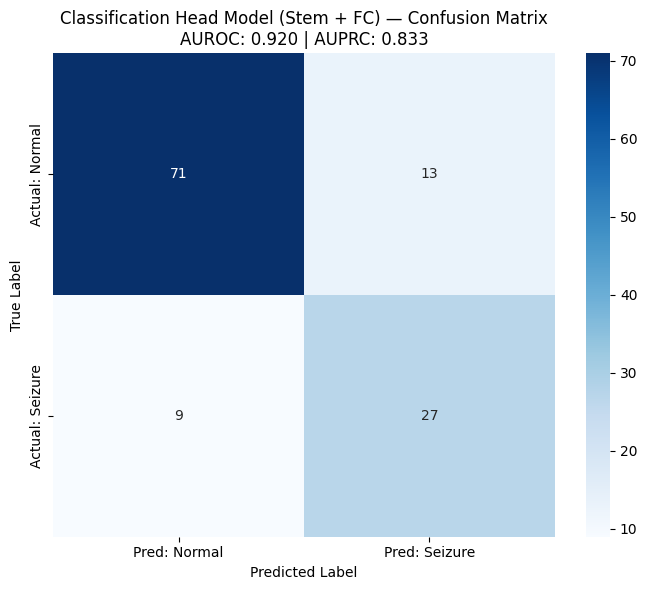

In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    average_precision_score
)

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_full_testing(model, test_loader, model_name="Model"):
    """
    Scientific evaluation on the 20% RANDOM TEST FILES.
    Assumes test_loader was built from `test_files`.
    """

    if model is None or test_loader is None:
        print("❌ Model or test_loader missing.")
        return

    model.eval()
    print(f"🔬 Starting Scientific Evaluation for {model_name} on {DEVICE}...")

    all_preds = []
    all_labels = []
    all_probs = []

    # ==========================================
    # EVALUATION LOOP
    # ==========================================
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)

            # Probability of seizure (class 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # ==========================================
    # METRICS
    # ==========================================
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    report = classification_report(
        all_labels,
        all_preds,
        target_names=['Normal (Interictal)', 'Seizure (Ictal)']
    )

    cm = confusion_matrix(all_labels, all_preds)

    # ==========================================
    # PRINT RESULTS
    # ==========================================
    print("\n" + "=" * 60)
    print(f" SCIENTIFIC RESULTS — {model_name}")
    print("=" * 60)
    print(f"Accuracy : {accuracy:.4f}")
    print(f"AUROC    : {auroc:.4f}")
    print(f"AUPRC    : {auprc:.4f}")
    print("-" * 60)
    print("Classification Report:")
    print(report)
    print("-" * 60)

    # ==========================================
    # VISUALIZATION
    # ==========================================
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Pred: Normal', 'Pred: Seizure'],
        yticklabels=['Actual: Normal', 'Actual: Seizure']
    )
    plt.title(f'{model_name} — Confusion Matrix\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION (EXPLICIT & SAFE)
# ==========================================

# Example usage — choose the model you trained:
# trained_frozen_model
# model_head
# trained_unfrozen_model

# ==========================================
# CORRECTED EXECUTION FOR CLASSIFICATION HEAD
# ==========================================

# We check for 'model_head', which is the variable name used
# in the "Head Training" cell (Cell 7).

if 'model_head' in globals() and 'test_loader' in globals():
    run_full_testing(
        model_head,   # <--- CORRECTED: Passing the Head-Only model
        test_loader,
        model_name="Classification Head Model (Stem + FC)"
    )
else:
    print("⚠️ 'model_head' variable not found.")
    print("Please make sure you ran the 'Head Training Strategy' cell above.")


unfrozen backbone

In [57]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20

print(f"✅ Training Unfrozen Model on: {DEVICE}")

# ==========================================
# 1. VERIFY DATALOADERS (From Previous Cells)
# ==========================================
if 'train_loader' not in globals() or 'test_loader' not in globals():
    raise ValueError("❌ DataLoaders not found! Please run the 'Data Loading & Convert' cell first.")
else:
    print("✅ Using existing train_loader and test_loader.")

# ==========================================
# 2. MODEL SETUP (Unfrozen / Full Fine-Tuning)
# ==========================================
def build_unfrozen_model():
    print("Initializing ShuffleNet (Unfrozen Backbone Strategy)...")
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    model = models.shufflenet_v2_x0_5(weights=weights)

    # Adapt input for 160 channels (Modifying Stem)
    # This matches the architecture of your other model for fair comparison
    model.conv1[0] = nn.Conv2d(160, 24, kernel_size=3, stride=2, padding=1, bias=False)

    # Update classification head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    # UNFREEZE ALL LAYERS (Full Fine-Tuning)
    for param in model.parameters():
        param.requires_grad = True

    return model.to(DEVICE)

# Create the model
model_unfrozen = build_unfrozen_model()

# ==========================================
# 3. OPTIMIZER & CRITERION
# ==========================================
# Optimize ALL parameters
optimizer = optim.Adam(model_unfrozen.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 4. TRAINING LOOP
# ==========================================
print("\n--- Starting Full Fine-Tuning ---")
for epoch in range(NUM_EPOCHS):
    model_unfrozen.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_unfrozen(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    # Average loss
    epoch_loss /= len(train_loader.dataset)

    # --- QUICK EVALUATION (Per Epoch) ---
    model_unfrozen.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_unfrozen(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Loss: {epoch_loss:.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

print("✅ Training Complete.")

✅ Training Unfrozen Model on: cuda
✅ Using existing train_loader and test_loader.
Initializing ShuffleNet (Unfrozen Backbone Strategy)...

--- Starting Full Fine-Tuning ---
Epoch 01/20 | Loss: 0.6883 | AUROC: 0.4573 | AUPRC: 0.2668
Epoch 02/20 | Loss: 0.6789 | AUROC: 0.5856 | AUPRC: 0.3827
Epoch 03/20 | Loss: 0.6608 | AUROC: 0.6227 | AUPRC: 0.4364
Epoch 04/20 | Loss: 0.6095 | AUROC: 0.6815 | AUPRC: 0.4987
Epoch 05/20 | Loss: 0.5516 | AUROC: 0.6921 | AUPRC: 0.5166
Epoch 06/20 | Loss: 0.4828 | AUROC: 0.7269 | AUPRC: 0.5344
Epoch 07/20 | Loss: 0.4402 | AUROC: 0.7708 | AUPRC: 0.6609
Epoch 08/20 | Loss: 0.3561 | AUROC: 0.7831 | AUPRC: 0.6726
Epoch 09/20 | Loss: 0.2824 | AUROC: 0.8075 | AUPRC: 0.6992
Epoch 10/20 | Loss: 0.2371 | AUROC: 0.8009 | AUPRC: 0.6882
Epoch 11/20 | Loss: 0.2166 | AUROC: 0.7718 | AUPRC: 0.6637
Epoch 12/20 | Loss: 0.1599 | AUROC: 0.7794 | AUPRC: 0.6558
Epoch 13/20 | Loss: 0.1493 | AUROC: 0.8069 | AUPRC: 0.7045
Epoch 14/20 | Loss: 0.1454 | AUROC: 0.8304 | AUPRC: 0.7458
E

🔬 Evaluating Unfrozen Model (Full Fine-Tuning)...

--- UNFROZEN MODEL RESULTS ---
Accuracy: 0.8250 (82.50%)
AUROC:    0.8485
AUPRC:    0.7225
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.88      0.88        84
     Seizure       0.71      0.69      0.70        36

    accuracy                           0.82       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.82      0.82      0.82       120



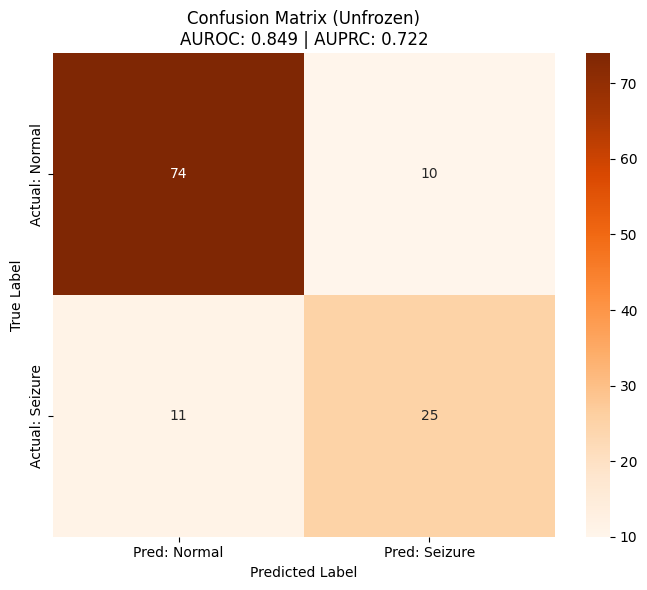

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_unfrozen_performance(model, test_loader):
    """
    Evaluates a fully unfrozen (fine-tuned) model on the test set.

    Computes Accuracy, AUROC, AUPRC, classification report, and plots the confusion matrix.
    """
    if model is None or test_loader is None:
        print("❌ Model or test_loader not found. Run training first.")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []  # Required for AUROC/AUPRC

    print("🔬 Evaluating Unfrozen Model (Full Fine-Tuning)...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Probabilities for Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Hard predictions
            _, preds = torch.max(outputs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(f"\n--- UNFROZEN MODEL RESULTS ---")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"AUROC:    {auroc:.4f}")
    print(f"AUPRC:    {auprc:.4f}")
    print("-" * 50)
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Seizure']))

    # --- PLOT CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Unfrozen)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
if 'model_unfrozen' in globals() and 'test_loader' in globals():
    test_unfrozen_performance(model_unfrozen, test_loader)
else:
    print("❌ 'model_unfrozen' or 'test_loader' not found. Run the unfrozen training cell first.")


converter a

In [59]:
import os
import random  # Added for shuffling
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score, average_precision_score
from torchvision import models

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 10
N_STACK = 10  # Downsampling factor for Converter A

# ==========================================
# 1. LOAD & CONVERT (Converter A + RANDOM SHUFFLE)
# ==========================================
def load_converter_a_random(search_path="."):
    all_files = []
    for root, _, filenames in os.walk(search_path):
        for filename in filenames:
            if filename.endswith(".mat") and 'new_tests' not in root:
                all_files.append(os.path.join(root, filename))

    # [MODIFIED] Random Shuffle instead of Sort
    random.seed(42)
    random.shuffle(all_files)

    processed_data = []
    labels = []

    print(f"Processing {len(all_files)} files using Converter A (Random Order)...")

    for fpath in all_files:
        fname = os.path.basename(fpath).lower()
        label = 0.0 if "interictal" in fname else 1.0 if "ictal" in fname else None
        if label is None: continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Z-score normalization
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # Downsample by factor N_STACK (Converter A)
            x = raw_data[:, ::N_STACK]  # shape: [channels, time]
            processed_data.append(x)
            labels.append(label)
        except:
            continue

    X_tensor = torch.tensor(np.array(processed_data)).unsqueeze(1)  # [N, 1, C, T]
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

# Load Data
X_all_A, y_all_A = load_converter_a_random()

# ==========================================
# 2. RANDOM STRATIFIED 80/20 SPLIT
# ==========================================
# Get indices for each class
interictal_idx = torch.where(y_all_A == 0)[0]
ictal_idx = torch.where(y_all_A == 1)[0]

# [MODIFIED] Shuffle the indices to ensure random split
torch.manual_seed(42)
interictal_idx = interictal_idx[torch.randperm(len(interictal_idx))]
ictal_idx = ictal_idx[torch.randperm(len(ictal_idx))]

# Calculate split points
split_inter = int(len(interictal_idx) * 0.8)
split_ictal = int(len(ictal_idx) * 0.8)

# Construct Train/Test sets
train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

# Final Shuffle of Train Indices (to mix classes in batches)
train_indices = train_indices[torch.randperm(len(train_indices))]

X_train, y_train = X_all_A[train_indices], y_all_A[train_indices]
X_test, y_test = X_all_A[test_indices], y_all_A[test_indices]

# Weighted Sampler for Balance
train_labels = y_train.numpy()
class_counts = np.bincount(train_labels)
weights = 1. / class_counts
sample_weights = weights[train_labels]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

train_loader_A = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
test_loader_A = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Converter A (Random) Ready. Train: {len(X_train)}, Test: {len(X_test)}")

# ==========================================
# 3. MODEL & TRAINING (Converter A)
# ==========================================
# Training from Scratch (weights=None) because input is 1-channel, not 3-channel
model_A = models.shufflenet_v2_x0_5(weights=None)

# Adapt first layer for 1 Channel input (instead of 3)
model_A.conv1[0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Adapt output head
model_A.fc = nn.Linear(model_A.fc.in_features, 2)
model_A.to(DEVICE)

optimizer = optim.Adam(model_A.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Training (Converter A + Random Split) ---")
for epoch in range(NUM_EPOCHS):
    model_A.train()
    epoch_loss = 0
    for inputs, labels in train_loader_A:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_A(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Evaluation
    model_A.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader_A:
            inputs = inputs.to(DEVICE)
            outputs = model_A(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
    except:
        auroc, auprc = 0.5, 0.0

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss/len(train_loader_A):.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

Processing 596 files using Converter A (Random Order)...
✅ Converter A (Random) Ready. Train: 476, Test: 120

--- Starting Training (Converter A + Random Split) ---
Epoch 1/10 | Loss: 0.7469 | AUROC: 0.5086 | AUPRC: 0.2922
Epoch 2/10 | Loss: 0.7437 | AUROC: 0.5999 | AUPRC: 0.4667
Epoch 3/10 | Loss: 0.7270 | AUROC: 0.5397 | AUPRC: 0.3355
Epoch 4/10 | Loss: 0.6796 | AUROC: 0.6075 | AUPRC: 0.3937
Epoch 5/10 | Loss: 0.6571 | AUROC: 0.6233 | AUPRC: 0.4088
Epoch 6/10 | Loss: 0.6640 | AUROC: 0.5969 | AUPRC: 0.3740
Epoch 7/10 | Loss: 0.5968 | AUROC: 0.5347 | AUPRC: 0.4608
Epoch 8/10 | Loss: 0.5217 | AUROC: 0.5179 | AUPRC: 0.4512
Epoch 9/10 | Loss: 0.5279 | AUROC: 0.5837 | AUPRC: 0.5199
Epoch 10/10 | Loss: 0.4625 | AUROC: 0.5883 | AUPRC: 0.4931


Evaluating Converter A Model (Downsampling Strategy)...

--- CONVERTER A SCIENTIFIC RESULTS ---
Overall Accuracy: 0.5917 (59.17%)
AUROC Score:      0.5883
AUPRC Score:      0.4931
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.75      0.62      0.68        84
     Seizure       0.37      0.53      0.44        36

    accuracy                           0.59       120
   macro avg       0.56      0.57      0.56       120
weighted avg       0.64      0.59      0.61       120



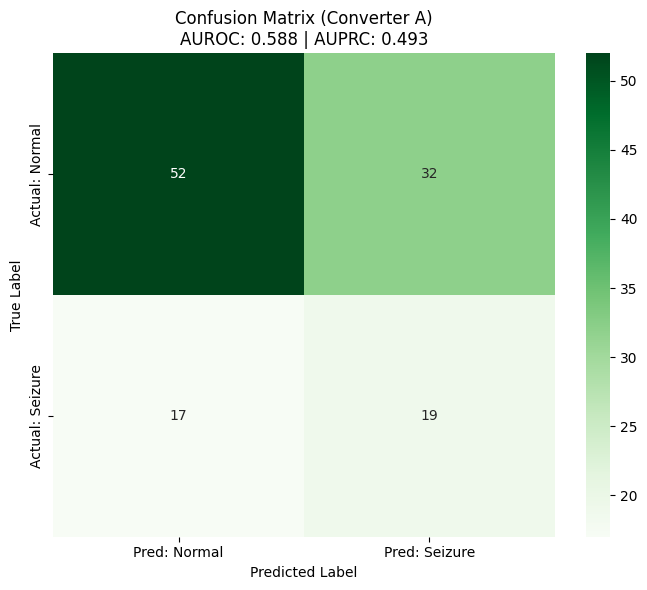

In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score

def test_converter_a_performance(model, test_loader):
    """
    Evaluate the Converter A model on the test set.
    Computes Accuracy, AUROC, AUPRC, Classification Report, and Confusion Matrix.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    print("Evaluating Converter A Model (Downsampling Strategy)...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Extract probabilities for Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print("\n--- CONVERTER A SCIENTIFIC RESULTS ---")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"AUROC Score:      {auroc:.4f}")
    print(f"AUPRC Score:      {auprc:.4f}")
    print("-" * 50)
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Seizure']))

    # --- CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Converter A)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


# Run Evaluation for Converter A
if 'model_A' in globals() and 'test_loader_A' in globals():
    test_converter_a_performance(model_A, test_loader_A)
else:
    print("'model_A' or 'test_loader_A' not found. Please run the Converter A training cell first.")


scratch

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

print(f"✅ Training Model FROM SCRATCH on: {DEVICE}")

# ==========================================
# 1. VERIFY DATALOADERS (Use Existing Random Split)
# ==========================================
if 'train_loader' not in globals() or 'test_loader' not in globals():
    print("❌ DataLoaders not found. Please run the 'Data Loading' cell first.")
else:
    print(f"✅ Using existing Random Split DataLoaders.")
    print(f"   Train Batches: {len(train_loader)}")
    print(f"   Test Batches:  {len(test_loader)}")

# ==========================================
# 2. MODEL SETUP (FROM SCRATCH)
# ==========================================
def build_scratch_model():
    print("Initializing ShuffleNet V2 (FROM SCRATCH - Random Weights)...")
    # weights=None ensures we are NOT using ImageNet transfer learning
    model = models.shufflenet_v2_x0_5(weights=None)

    # Adapt input for 160 channels (Matching Converter B)
    model.conv1[0] = nn.Conv2d(160, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # Classification Head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    return model.to(DEVICE)

model_scratch = build_scratch_model()

# ==========================================
# 3. OPTIMIZER & TRAINING
# ==========================================
optimizer = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Training (Scratch Baseline) ---")
for epoch in range(NUM_EPOCHS):
    model_scratch.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_scratch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    # Average loss
    epoch_loss /= len(train_loader.dataset)

    # Evaluation
    model_scratch.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_scratch(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
    except:
        auroc, auprc = 0.5, 0.0

    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Loss: {epoch_loss:.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

✅ Training Model FROM SCRATCH on: cuda
✅ Using existing Random Split DataLoaders.
   Train Batches: 30
   Test Batches:  8
Initializing ShuffleNet V2 (FROM SCRATCH - Random Weights)...

--- Starting Training (Scratch Baseline) ---
Epoch 01/20 | Loss: 0.8183 | AUROC: 0.3892 | AUPRC: 0.2919
Epoch 02/20 | Loss: 0.6872 | AUROC: 0.5830 | AUPRC: 0.3653
Epoch 03/20 | Loss: 0.6874 | AUROC: 0.4831 | AUPRC: 0.2976
Epoch 04/20 | Loss: 0.6648 | AUROC: 0.5549 | AUPRC: 0.3482
Epoch 05/20 | Loss: 0.6904 | AUROC: 0.5261 | AUPRC: 0.4365
Epoch 06/20 | Loss: 0.6711 | AUROC: 0.5734 | AUPRC: 0.3833
Epoch 07/20 | Loss: 0.6570 | AUROC: 0.6524 | AUPRC: 0.4459
Epoch 08/20 | Loss: 0.5922 | AUROC: 0.7636 | AUPRC: 0.4877
Epoch 09/20 | Loss: 0.5928 | AUROC: 0.7907 | AUPRC: 0.6789
Epoch 10/20 | Loss: 0.5309 | AUROC: 0.7216 | AUPRC: 0.5570
Epoch 11/20 | Loss: 0.4887 | AUROC: 0.7609 | AUPRC: 0.5262
Epoch 12/20 | Loss: 0.4679 | AUROC: 0.7751 | AUPRC: 0.5724
Epoch 13/20 | Loss: 0.4460 | AUROC: 0.7979 | AUPRC: 0.6686
Ep

Evaluating Model Trained from Scratch...

--- LEARNING FROM SCRATCH RESULTS ---
 Overall Accuracy: 0.8083 (80.83%)
 AUROC Score:      0.8608
 AUPRC Score:      0.7768
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.84      0.89      0.87        84
     Seizure       0.71      0.61      0.66        36

    accuracy                           0.81       120
   macro avg       0.78      0.75      0.76       120
weighted avg       0.80      0.81      0.80       120



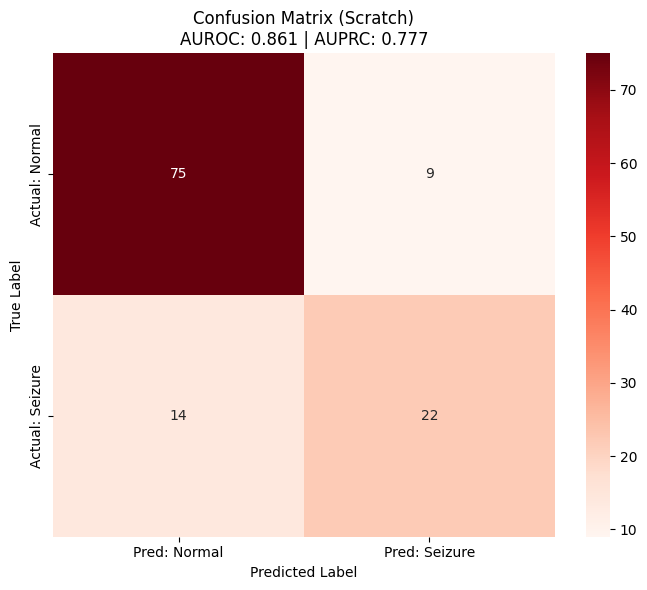

In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_scratch_model(model, test_loader):
    """
    Evaluates a Scratch-trained model with scientific metrics:
    Accuracy, AUROC, AUPRC, Confusion Matrix.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for class 1 (Seizure)

    print("Evaluating Model Trained from Scratch...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Seizure probability (class 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)

    # Handle edge case if only one class present
    try:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
    except ValueError:
        auroc = float('nan')
        auprc = float('nan')

    report = classification_report(all_labels, all_preds,
                                   target_names=['Normal', 'Seizure'])
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n--- LEARNING FROM SCRATCH RESULTS ---")
    print(f" Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f" AUROC Score:      {auroc:.4f}")
    print(f" AUPRC Score:      {auprc:.4f}")
    print("-" * 50)
    print(report)

    # --- CONFUSION MATRIX ---
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Scratch)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


# --- RUN EVALUATION ---
if 'model_scratch' in globals() and 'test_loader' in globals():
    test_scratch_model(model_scratch, test_loader)
else:
    print(" 'model_scratch' or 'test_loader' not found. Run the scratch training cell first!")
